# Quuantum Teleportation

このノートブックは、量子テレポーテーションを示しています。最初にQiskitの組み込みシミュレーターを使用して、量子回路をテストし、次に実際の量子コンピュータで試してみます。

## 1. Overview

アリスはボブに量子情報を送信したいと考えています。具体的には、彼女がqubit状態 |ψ> = α|0> + β|1>を送信したいとします。これにはαとβに関する情報をボブに渡す必要があります。

未知の量子状態の正確なコピーを単純に作成することはできないという量子力学の定理が存在します。これは、"no-cloning theorem(非クローニング定理)"として知られています。この結果、アリスは|ψ>のコピーを生成してボブに渡すことができないことがわかります。コピーできるのは古典的な状態のみです。(重ね合わせは不可)

ただし、2つの古典的なbitと、もつれたqubitのペアを利用することにより、アリスは自分の状態|ψ>をボブに転送することができます。私たちはこのテレポートを、最後にボブが持つことになると呼び、アリスの手元にはもうありません。

## 2. The Quantum Teleportation Protocol

qubitを転送するには、アリスとボブはサードパーティ(イブ)を使用して、絡み合ったqubitのペアを送信する必要があります。アリスは、qubitに対して幾つかの操作を実行し、その結果を従来の通信チャネルを介してボブに送信し、ボブは、アリスのqubitを受信するために自分の側で幾つかの操作を実行します。

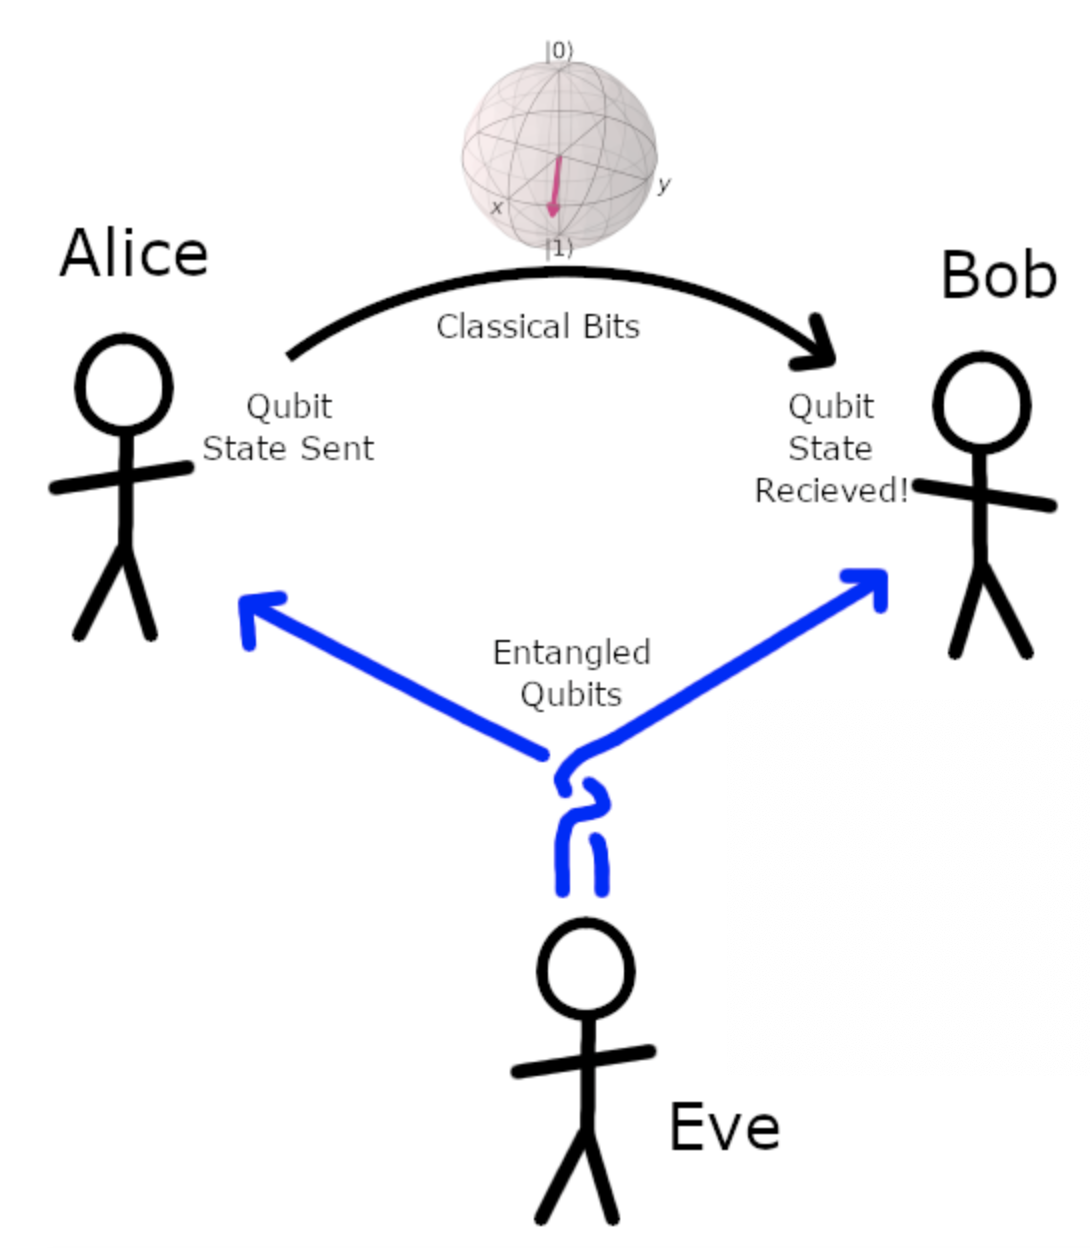

以下に量子回路の手順を説明します。ここでは、実際に「送信」されるqubitはありません。その部分は想像するだけです！

まずは、セッションをセットアップします。

In [2]:
# Do the necessary imports
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, BasicAer, IBMQ
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.extensions import Initialize

そして、量子回路を作成しましょう。

In [3]:
qr = QuantumRegister(3)    # Protocol uses 3 qubits
crz = ClassicalRegister(1) # and 2 classical bits
crx = ClassicalRegister(1) # in 2 different registers
teleportation_circuit = QuantumCircuit(qr, crz, crx)

### Step 1

サードパーティーのイブは、絡み合ったqubitのペアを作成し、1つをボブに、もう1つをアリスに与えます。

イブが作成するペアは、"Bell pair(ベルペア)"と呼ばれる特別なペアです。量子回路言語では、2つのqubit間でベルペアを作成する方法は、アダマールゲートを使用して、それらの1つをX基底(|+>および|->)に最初に転送し、次にCNOTゲートをX基底のqubitに制御されているqubitに適用します。

In [4]:
def create_bell_pair(qc, a, b):
    """Creates a bell pair in qc using qubits a & b"""
    qc.h(a) # Put qubit a into state |+>
    qc.cx(a,b) # CNOT with a as control and b as target

In [5]:
## SETUP
# Protocol uses 3 qubits and 2 classical bits in 2 different registers
qr = QuantumRegister(3)
crz, crx = ClassicalRegister(1), ClassicalRegister(1)
teleportation_circuit = QuantumCircuit(qr, crz, crx)

## STEP 1
# In our case, Eve entangles qubits q1 and q2
# Let's apply this to our circuit:
create_bell_pair(teleportation_circuit, 1, 2)
# And view the circuit so far:
teleportation_circuit.draw()

q1_0: ──────────
      ┌───┐     
q1_1: ┤ H ├──■──
      └───┘┌─┴─┐
q1_2: ─────┤ X ├
           └───┘
c2_0: ══════════
                
c3_0: ══════════

2人に配られた時、アリスが所有したのがqi、ボブが所有したのをq2とします。

### Step 2

In [6]:
def alice_gates(qc, psi, a):
    qc.cx(psi, a)
    qc.h(psi)

In [7]:
## SETUP
# Protocol uses 3 qubits and 2 classical bits in 2 different registers
qr = QuantumRegister(3)
crz, crx = ClassicalRegister(1), ClassicalRegister(1)
teleportation_circuit = QuantumCircuit(qr, crz, crx)

## STEP 1
create_bell_pair(teleportation_circuit, 1, 2)

## STEP 2
teleportation_circuit.barrier() # Use barrier to separate steps
alice_gates(teleportation_circuit, 0, 1)
teleportation_circuit.draw()

░      ┌───┐
q2_0: ───────────░───■──┤ H ├
      ┌───┐      ░ ┌─┴─┐└───┘
q2_1: ┤ H ├──■───░─┤ X ├─────
      └───┘┌─┴─┐ ░ └───┘     
q2_2: ─────┤ X ├─░───────────
           └───┘ ░           
c4_0: ═══════════════════════
                             
c5_0: ═══════════════════════

### Step 3

次に、アリスは自分が所有する両方のqubit、q1と|ψ>に測定値を適用し、この結果を古典的なbitに格納します。次に、これらの2bitをボブに送信します。

In [8]:
def measure_and_send(qc, a, b):
    """Measures qubits a & b and 'sends' the results to Bob"""
    qc.barrier()
    qc.measure(a,0)
    qc.measure(b,1)

In [9]:
## SETUP
# Protocol uses 3 qubits and 2 classical bits in 2 different registers
qr = QuantumRegister(3)
crz, crx = ClassicalRegister(1), ClassicalRegister(1)
teleportation_circuit = QuantumCircuit(qr, crz, crx)

## STEP 1
create_bell_pair(teleportation_circuit, 1, 2)

## STEP 2
teleportation_circuit.barrier() # Use barrier to separate steps
alice_gates(teleportation_circuit, 0, 1)

## STEP 3
measure_and_send(teleportation_circuit, 0 ,1)
teleportation_circuit.draw()

░      ┌───┐ ░ ┌─┐   
q3_0: ───────────░───■──┤ H ├─░─┤M├───
      ┌───┐      ░ ┌─┴─┐└───┘ ░ └╥┘┌─┐
q3_1: ┤ H ├──■───░─┤ X ├──────░──╫─┤M├
      └───┘┌─┴─┐ ░ └───┘      ░  ║ └╥┘
q3_2: ─────┤ X ├─░────────────░──╫──╫─
           └───┘ ░            ░  ║  ║ 
c6_0: ═══════════════════════════╩══╬═
                                    ║ 
c7_0: ══════════════════════════════╩═

### Step 4

既にqubit q2を持っているボブは、古典的なビットの状態に応じて次のゲートを適用します。

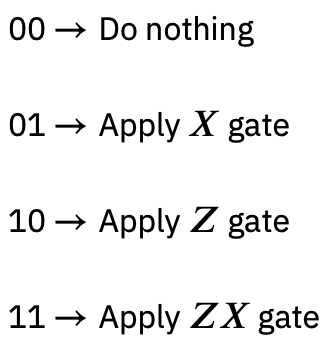

(この情報の転送は純粋に古典的なものであることに注意してください。)

In [10]:
# This function takes a QuantumCircuit (qc), integer (qubit)
# and ClassicalRegisters (crz & crx) to decide which gates to apply
def bob_gates(qc, qubit, crz, crx):
    # Here we use c_if to control our gates with a classical
    # bit instead of a qubit
    qc.x(qubit).c_if(crx, 1) # Apply gates if the registers 
    qc.z(qubit).c_if(crz, 1) # are in the state '1'

In [11]:
## SETUP
# Protocol uses 3 qubits and 2 classical bits in 2 different registers
qr = QuantumRegister(3)
crz, crx = ClassicalRegister(1), ClassicalRegister(1)
teleportation_circuit = QuantumCircuit(qr, crz, crx)

## STEP 1
create_bell_pair(teleportation_circuit, 1, 2)

## STEP 2
teleportation_circuit.barrier() # Use barrier to separate steps
alice_gates(teleportation_circuit, 0, 1)

## STEP 3
measure_and_send(teleportation_circuit, 0 ,1)

## STEP 4
teleportation_circuit.barrier() # Use barrier to separate steps
bob_gates(teleportation_circuit, 2, crz, crx)
teleportation_circuit.draw()

░      ┌───┐ ░ ┌─┐    ░               
q4_0: ───────────░───■──┤ H ├─░─┤M├────░───────────────
      ┌───┐      ░ ┌─┴─┐└───┘ ░ └╥┘┌─┐ ░               
q4_1: ┤ H ├──■───░─┤ X ├──────░──╫─┤M├─░───────────────
      └───┘┌─┴─┐ ░ └───┘      ░  ║ └╥┘ ░  ┌───┐  ┌───┐ 
q4_2: ─────┤ X ├─░────────────░──╫──╫──░──┤ X ├──┤ Z ├─
           └───┘ ░            ░  ║  ║  ░  └─┬─┘  └─┬─┘ 
                                 ║  ║       │   ┌──┴──┐
c8_0: ═══════════════════════════╩══╬═══════╪═══╡ = 1 ╞
                                    ║    ┌──┴──┐└─────┘
c9_0: ══════════════════════════════╩════╡ = 1 ╞═══════
                                         └─────┘

そして出来上がり！このプロトコルの終わりに、アリスのqubitはボブの元にテレポートしました。

## 3. Simulating the Teleportation Protocol

### 3.1 How Will We Test the Protocol on a Quaantum Computer?

このノートでは、ランダムな状態(|ψ>)でアリスのqubitを初期化します。この状態は|90>の初期化ゲートを使用して作成されます。この章では、関数"random_state"を使用してψを選択しますが、ψを任意のqubit状態に自由に設定できます。

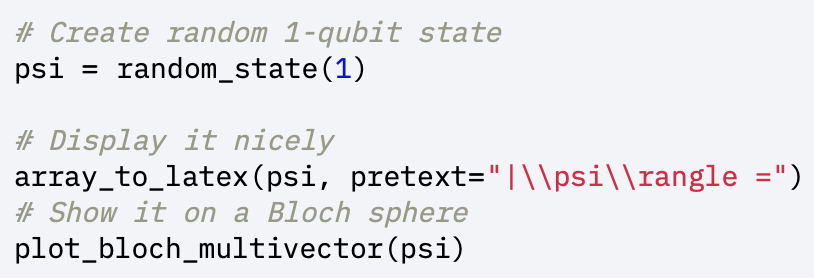

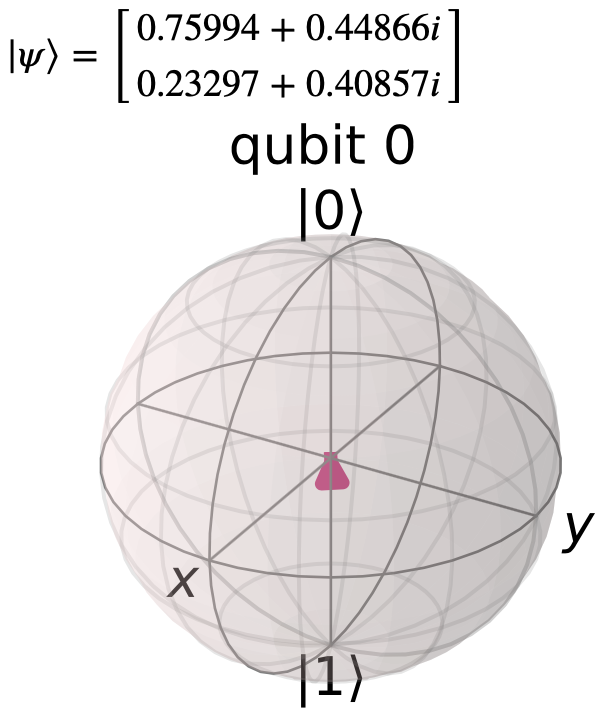

|0>から|ψ>を作成するための初期化ゲートを作成しましょう。

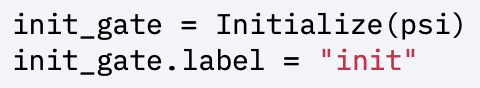

量子テレポーテーション回路が機能している場合、回路の最後でqubit|q2>はこの状態になります。これは、statevectorシミュレーターを使用して確認します。

### 3.2 Using the Statevector Simulator

statevectorシミュレーターを使用して、qubitがテレポートされたことを確認できます。

In [14]:
## SETUP
qr = QuantumRegister(3)   # Protocol uses 3 qubits
crz = ClassicalRegister(1) # and 2 classical registers
crx = ClassicalRegister(1)
qc = QuantumCircuit(qr, crz, crx)

## STEP 0
# First, let's initialise Alice's q0
qc.append(init_gate, [0])
qc.barrier()

## STEP 1
# Now begins the teleportation protocol
create_bell_pair(qc, 1, 2)
qc.barrier()

## STEP 2
# Send q1 to Alice and q2 to Bob
alice_gates(qc, 0, 1)

## STEP 3
# Alice then sends her classical bits to Bob
measure_and_send(qc, 0, 1)

## STEP 4
# Bob decodes qubits
bob_gates(qc, 2, crz, crx)

# Display the circuit
qc.draw()

NameError: name 'init_gate' is not defined